In [65]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, GRU, Dense, Dropout, Embedding, Concatenate, Flatten, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
from sklearn.metrics import mean_squared_error

**Data Preprocessing**

In [67]:
df=pd.read_csv('Dataset.csv')

In [68]:
df.head()

,Date,Description,Debit,Credit,Sub-category,Category,Category Type,Month Number,Weekday,Amount
0,2021-01-04,Data With Decision,NaN,5000.0,Data with Decision,Salary,Income,1,1900-01-02,5000.0
1,2021-01-04,Drink,5.0,NaN,Coffee,Dining Out,Expense,1,1900-01-02,-5.0
2,2021-01-05,Estate Mangement,900.0,NaN,Rent,Living Expenses,Expense,1,1900-01-03,-900.0
3,2021-01-05,Financail upgrade,150.0,NaN,Cash loan,Transport,Expense,1,1900-01-03,-150.0
4,2021-01-05,Drink,5.0,NaN,Coffee,Dining Out,Expense,1,1900-01-03,-5.0


In [69]:
df["Date"] = pd.to_datetime(df["Date"])

df["Income"] = df["Amount"].apply(lambda x: x if x > 0 else 0)
df["Expense"] = df["Amount"].apply(lambda x: abs(x) if x < 0 else 0)

# Aggregate to monthly totals
monthly_data = (
    df.groupby(pd.Grouper(key="Date", freq="M"))
    .agg({"Income": "sum", "Expense": "sum"})
    .reset_index()
)
monthly_data["Savings"] = monthly_data["Income"] - monthly_data["Expense"]

# Set the day to the 1st of the month
monthly_data["Date"] = (
    monthly_data["Date"] - pd.offsets.MonthEnd() + pd.offsets.MonthBegin(1)
)

monthly_data

,Date,Income,Expense,Savings
0,2021-01-01,14000.0,2874.0,11126.0
1,2021-02-01,5800.0,2904.6,2895.4
2,2021-03-01,6000.0,3049.7,2950.3
3,2021-04-01,7340.0,3038.0,4302.0
4,2021-05-01,6000.0,3116.1,2883.9
5,2021-06-01,5100.0,3005.7,2094.3
6,2021-07-01,5200.0,3065.0,2135.0
7,2021-08-01,5800.0,2952.1,2847.9
8,2021-09-01,5100.0,3087.1,2012.9
9,2021-10-01,5100.0,3098.7,2001.3


In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
monthly_data= scaler.fit_transform(monthly_data[["Income", "Expense", "Savings"]])
df_scaled = pd.DataFrame(monthly_data, columns=["Income", "Expense", "Savings"])

In [144]:
df_scaled

,Income,Expense,Savings
0,1.000000,0.000000,1.000000
1,0.078652,0.053940,0.097987
2,0.101124,0.309713,0.104003
3,0.251685,0.289089,0.252140
4,0.101124,0.426758,0.096726
5,0.000000,0.232152,0.010192
6,0.011236,0.336683,0.014653
7,0.078652,0.137670,0.092781
8,0.000000,0.375639,0.001271
9,0.000000,0.396087,0.000000


Creating sequences

In [77]:
def create_sequences(data, seq_length, target_col):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])  # Slice the sequence
        y.append(data[i + seq_length, target_col])  # Target value
    X = np.array(X)  # Convert to NumPy array
    y = np.array(y)  # Convert to NumPy array
    return X, y


# Define sequence length and target column
seq_length = 3  # Use 12 months of data to predict the next month
target_col = 2  # Assuming "Savings" is the target column (index 2)

# Create sequences
X, y = create_sequences(monthly_data, seq_length, target_col)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**GRU Model**

In [125]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # GRU layers
    x = GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))(inputs)
    x = Dropout(0.2)(x)
    x = GRU(100, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)

    # Dense layers
    x = Dense(100, activation=LeakyReLU(alpha=0.1))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    return model


# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3, 3)]            0         
                                                                 
 gru_21 (GRU)                (None, 3, 50)             8250      
                                                                 
 dropout_29 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_22 (GRU)                (None, 100)               45600     
                                                                 
 dropout_30 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 100)               10100     
                                                                 
 dropout_31 (Dropout)        (None, 100)               0   

Training the model

In [139]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
1/1 [==============================] - 0s 126ms/step - loss: 0.0064 - val_loss: 0.0044 - lr: 2.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 96ms/step - loss: 0.0056 - val_loss: 0.0040 - lr: 2.0000e-04
Epoch 3/100
1/1 [==============================] - 0s 81ms/step - loss: 0.0057 - val_loss: 0.0037 - lr: 2.0000e-04
Epoch 4/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0057 - val_loss: 0.0034 - lr: 2.0000e-04
Epoch 5/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0061 - val_loss: 0.0033 - lr: 2.0000e-04
Epoch 6/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0065 - val_loss: 0.0032 - lr: 2.0000e-04
Epoch 7/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0058 - val_loss: 0.0033 - lr: 2.0000e-04
Epoch 8/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0057 - val_loss: 0.0035 - lr: 2.0000e-04
Epoch 9/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0059 

Predictions

1/1 [==============================] - 0s 33ms/step
RMSE: 134.61517808199673


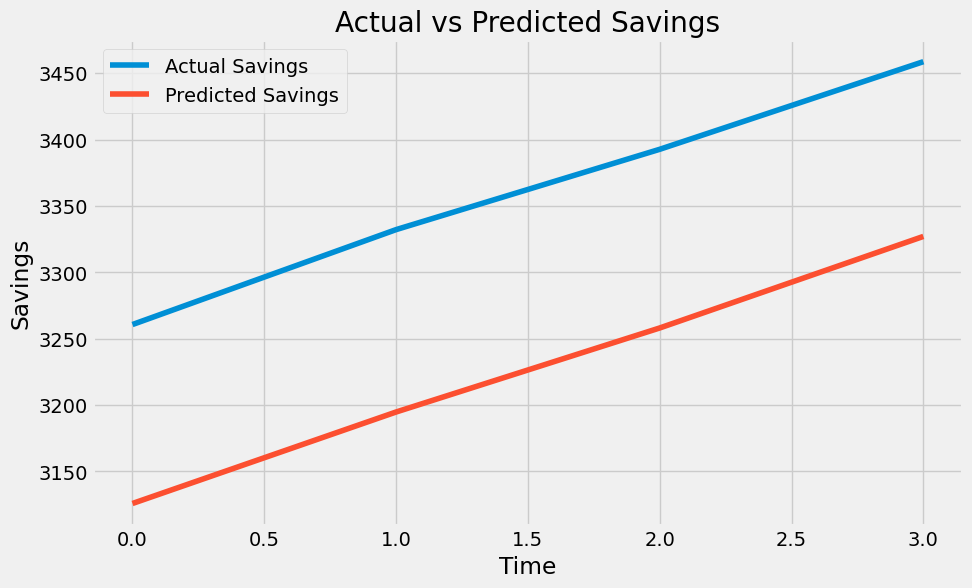

In [140]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_pred_original = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), 2)), y_pred.reshape(-1, 1)], axis=1)
)[:, 2]
y_test_original = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), 2)), y_test.reshape(-1, 1)], axis=1)
)[:, 2]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RMSE: {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Savings")
plt.plot(y_pred_original, label="Predicted Savings")
plt.title("Actual vs Predicted Savings")
plt.xlabel("Time")
plt.ylabel("Savings")
plt.legend()
plt.show()

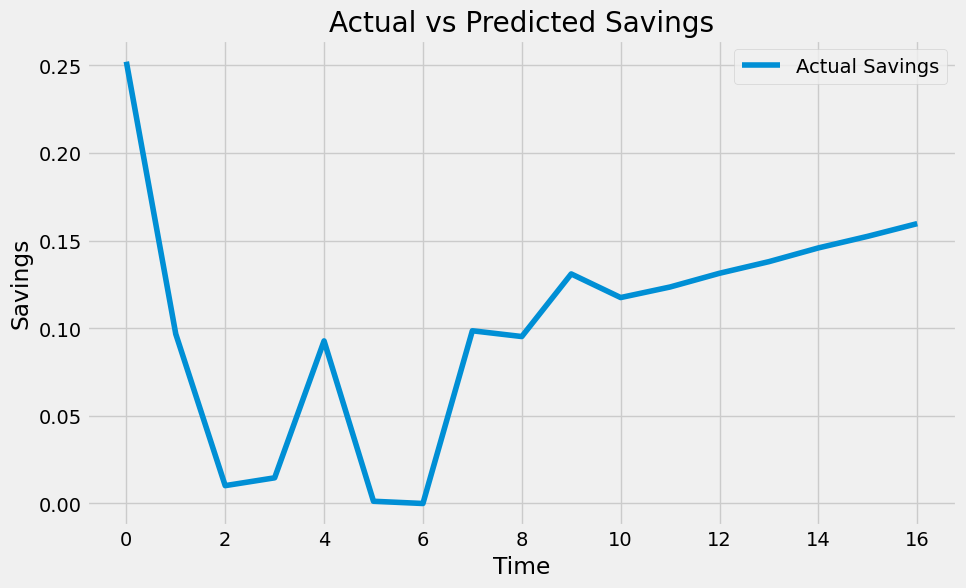

In [141]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y, label="Actual Savings")
plt.title("Actual vs Predicted Savings")
plt.xlabel("Time")
plt.ylabel("Savings")
plt.legend()
plt.show()

In [142]:
# Check if y_pred and y_test are computed
print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test:", y_test.shape)

# Print the first few values of y_pred and y_test
print("predictions:", y_pred_original[:5])
print("actual values:", y_test_original[:5])

Shape of y_pred: (4, 1)
Shape of y_test: (4,)
predictions: [3125.89888134 3194.81546299 3258.11429693 3327.072417  ]
actual values: [3260.7 3332.2 3392.7 3458.7]


In [143]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}")

1/1 [==============================] - 0s 42ms/step - loss: 0.0032
Test MSE: 0.0032272262033075094
